In [124]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
from torch import nn
import torch
import os
import torch.optim as optim
import warnings 
from utils import *
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
torch.cuda.is_available()
os.listdir('../model')

['Critic.pkl', 'PAagent.pkl', 'stream_lasso_weight.pkl']

In [125]:
os.listdir('../data')

['dataset.pkl', 'tag_cleaned.csv', 'train_cleaned.csv']

In [126]:
tag = pd.read_csv('../data/tag_cleaned.csv')
tag_map = dict(zip(tag.TAG,tag.chinese))

# 讀取價值估計網路 , lasso權重 和 數據

In [127]:
critic = joblib.load('../model/Critic.pkl').eval()
lasso_w = torch.FloatTensor(joblib.load('../model/stream_lasso_weight.pkl'))

In [128]:
data = joblib.load('../data/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

# 資料 iter

In [129]:
state = torch.FloatTensor(data['state'])
request = torch.FloatTensor(np.random.uniform(0,1,size=(state.shape[0],1)))
real_action = torch.FloatTensor(data['action'])
state.shape,request.shape,real_action.shape

(torch.Size([59213, 2]), torch.Size([59213, 1]), torch.Size([59213, 36, 12]))

In [130]:
train = torch.utils.data.TensorDataset(state,request,real_action)
train_iter = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

# 建立神經網路 策略網路

In [131]:
data['action'].shape

(59213, 36, 12)

In [132]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_step = data['action'].shape[1]
        self.num_sensor = data['action'].shape[2]
        self.flat_size = self.time_step*self.num_sensor
        self.fc = nn.Sequential(nn.Linear(3,128),nn.ReLU(),nn.Linear(128,self.flat_size))
        
    def forward(self,state,request):
        action = self.fc(torch.cat((state,request),dim=1))
        action = action.view(-1,self.time_step,self.num_sensor)
        return F.sigmoid(action)

In [133]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0)
        except:
            pass

In [134]:
net = Actor()
net.apply(init_weights)

Actor(
  (fc): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=432, bias=True)
  )
)

# 前向傳遞測試

In [135]:
print(net(state,request).shape)

torch.Size([59213, 36, 12])


# 目標函數

In [136]:
time_step = data['action'].shape[1]
num_sensor = data['action'].shape[2]

In [137]:
loss_history = {}
loss_history['loss1'] = []
loss_history['loss2'] = []
loss_history['loss3'] = []
loss_history['loss4'] = []
loss_history['loss5'] = []
loss_history['loss6'] = []
loss_history['loss7'] = []

In [138]:
data['action_col']

['MLPAP_FQ-0619.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_FR-0632.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-1734.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TJ-0881.PV',
 'MLPAP_TJ-0757B.PV',
 '濃度']

In [139]:
def obj_function(action,state,request,real_action):
    
    # 價值網路預測出料
    output, _ = critic(state.cuda(),action.cuda())
    output = output.cpu()
    
    # lasso預測蒸氣
    batch_size = action.shape[0]
    A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
    stream = (A@lasso_w).reshape(-1,1)
    
    # 滿足使用者需求(預測出料等於期望出料)
    loss1 = ((request - output)**2).mean()
    
    # 最小化蒸氣量(愈小愈好)
    loss2 = (stream**2).mean()
    
    # 入料跟出料"質量平衡"
    feed = action.reshape(-1,time_step,num_sensor)[:,:,0]
    loss3 = ((1.0*feed - request)**2).mean()
    
    # 避免鹽浴"溫差太大"
    temp_1 = action.reshape(-1,time_step,num_sensor)[:,:,4]
    temp_2 = action.reshape(-1,time_step,num_sensor)[:,:,-1]
    loss4 = ((temp_1 - temp_2)**2).mean()
    
    # 避免"變異數太大(時間維度上)"
    loss5 = action.reshape(-1,time_step,num_sensor).std(axis=1)
    loss5 = loss5.sum(axis=-1).mean(axis=0) # instance wise => batch wise
    
    #濃度盡量接近90
    loss6 = (action.reshape(-1,time_step,num_sensor)[:,:,-1] - 0.92)**2
    loss6 = loss6.mean()
    
    #避免操作跟實際歷史數據差距太大
    loss7 = F.softplus((action.reshape(-1)-real_action.reshape(-1))**2 - 0.1,beta=5).mean()
    
    # 紀錄
    loss_history['loss1'].append(loss1.item())
    loss_history['loss2'].append(loss2.item())
    loss_history['loss3'].append(loss3.item())
    loss_history['loss4'].append(loss4.item())
    loss_history['loss5'].append(loss5.item())
    loss_history['loss6'].append(loss6.item())
    loss_history['loss7'].append(loss7.item())
    
    #由於最小化蒸氣量會導致入料跟著最小化會出問題 故將loss2*0
    #loss 1很重要所以乘上5倍
    return 5*loss1 + 0*loss2 + loss3 + loss4 + loss5 + loss6 + loss7

In [140]:
obj_function(net(state[[0]],request[[0]]),state[[0]],request[[0]],real_action[[0]])

tensor(0.8480, grad_fn=<AddBackward0>)

# 優化器

In [141]:
optimizer = optim.Adam(net.parameters(),lr=1e-3)

# 訓練流程

In [142]:
def train(net,train_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        
        for state,request,real_action in train_iter:
            action = net(state,request)
            loss = obj_function(action,state,request,real_action)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    return net

epochs 0 loss 0.2764
epochs 1 loss 0.1693
epochs 2 loss 0.1659
epochs 3 loss 0.1640
epochs 4 loss 0.1629
epochs 5 loss 0.1620
epochs 6 loss 0.1613
epochs 7 loss 0.1609
epochs 8 loss 0.1606
epochs 9 loss 0.1603
epochs 10 loss 0.1601
epochs 11 loss 0.1598
epochs 12 loss 0.1597
epochs 13 loss 0.1597
epochs 14 loss 0.1595
epochs 15 loss 0.1594
epochs 16 loss 0.1592
epochs 17 loss 0.1592
epochs 18 loss 0.1591
epochs 19 loss 0.1590
epochs 20 loss 0.1589
epochs 21 loss 0.1588
epochs 22 loss 0.1587
epochs 23 loss 0.1587
epochs 24 loss 0.1586
epochs 25 loss 0.1585
epochs 26 loss 0.1584
epochs 27 loss 0.1584
epochs 28 loss 0.1583
epochs 29 loss 0.1583


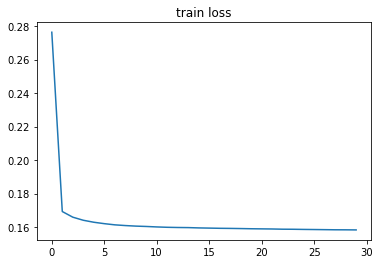

In [143]:
actor = train(net,train_iter,obj_function,optimizer,num_epochs=30)

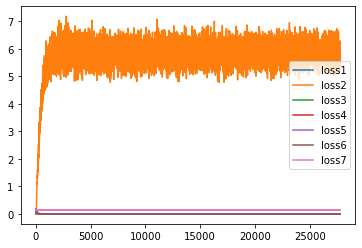

In [144]:
for k,v in loss_history.items():
    plt.plot(pd.Series(v).rolling(5).mean(),label=k)
plt.legend()
plt.show()

# 封裝成一個類 這個類有兩個方法 可以給出預測值 跟操作建議

In [145]:
class PA_ROBOT:
    def __init__(self):
        self.mm_output = data['mm_output']
        self.mm_stream = data['mm_stream']
        self.mm_state = data['mm_state']
        self.mm_action = data['mm_action']
        self.action_col = data['action_col']
        self.tag_map = tag_map
        self.actor = actor
        self.critic = critic
        self.lasso_w = lasso_w

    def get_predict(self,s,a):
        '''
        # 給定狀態跟動作 預測出料跟蒸氣
        '''
        feed = a.iloc[0,0]
        action = pd.DataFrame(index=[*range(36)],columns=self.action_col)
        for i in range(36):
            action.iloc[i,:] = a.values
        action = action.values
        
        state = self.mm_state.transform([s])
        action = self.mm_action.transform(action)
        action = np.expand_dims(action,axis=0)

        state = torch.FloatTensor(state)
        action = torch.FloatTensor(action)

        # 價值估計網路預測出料 但不取蒸氣 因為不準
        output,_ = self.critic(state.cuda(),action.cuda())

        # 用lasso預測蒸氣
        batch_size = action.shape[0]
        A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
        stream = (A@self.lasso_w).reshape(-1,1)

        # 把數值轉換成原本的值域
        output = output.detach().cpu().numpy()
        output = self.mm_output.inverse_transform(output)[0][0]
        stream = stream.detach().cpu().numpy()
        stream = self.mm_stream.inverse_transform(stream)[0][0]

        return output,stream,feed/output,feed/stream
    
    def get_advice(self,state,request):
        '''
        # 給定狀態和需求 輸出動作
        '''
        
        # 輸入值預處理
        request = self.mm_output.transform([[request]])
        state = self.mm_state.transform([state])
        request = torch.FloatTensor([request]).reshape(-1,1)
        state = torch.FloatTensor(state)
        
        # 輸出動作
        action = self.actor(state,request)
        
        # 把動作帶入價值估計網路預測出料 但不預測蒸氣因為不準
        output,_ = self.critic(state.cuda(),action.cuda())
        
        # lasso 預測蒸氣
        batch_size = action.shape[0]
        A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
        stream = (A@self.lasso_w).reshape(-1,1)
        
        # 把數值轉換成原本值域
        output = output.detach().cpu().numpy()
        output = self.mm_output.inverse_transform(output)
        stream = stream.detach().cpu().numpy()
        stream = self.mm_stream.inverse_transform(stream)
        action = action.detach().cpu().numpy()
        action = np.array([self.mm_action.inverse_transform(i) for i in action]).squeeze(0)
        
        # 把操作建議做成一張表格
        advice = pd.DataFrame(index = self.action_col)
        advice['chinese'] = advice.index.map(self.tag_map) 
        advice['mean'] = action.mean(axis=0)
        advice['max'] = action.max(axis=0)
        advice['min'] = action.min(axis=0)
        
        # 擷取入料
        feed = advice.loc['MLPAP_FQ-0619.PV','mean']

        # 返回操作建議,出料估計,蒸氣估計,單耗估計,蒸氣單耗估計
        return advice,output,stream,feed/output[0][0],feed/stream[0][0]

In [146]:
# 實例化這個類
robot = PA_ROBOT()

In [151]:
# 試用這個類
advice,output,stream,單耗,蒸氣單耗 = robot.get_advice([1.0,35],8200)
print('output:',output,'stream:',stream,'單耗',單耗,'蒸氣單耗',蒸氣單耗)
advice

[[1.03636001 0.79365073]]
output: [[8107.3965]] stream: [[11065.919]] 單耗 0.8916445 蒸氣單耗 0.6532594


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,7228.915527,7230.500977,7227.522461
MLPAP_TJC-0627.PV,OX預熱器出口溫度,151.367188,151.374069,151.360458
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,182.486053,182.527191,182.452042
MLPAP_FR-0632.PV,汽機風量,84.509384,84.511055,84.507011
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,362.348022,362.353180,362.343323
MLPAP_PIC-0761.PV,鹽浴冷卻器(E212)出口壓力,48.408962,48.419102,48.401119
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,58.587631,58.589912,58.584904
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,182.507355,182.538788,182.482651
MLPAP_TRC-0747.PV,E220出口溫度,168.673294,168.714325,168.623138
MLPAP_TJ-0881.PV,液態冷凝器出口溫度,136.957138,136.973480,136.945114


# 保存

In [152]:
joblib.dump(robot,'../model/PAagent.pkl')

['../model/PAagent.pkl']